---
format:
  html:
    other-links:
      - text: This notebook
        href: A9.ipynb
---

# A9: Latent Semantic Analysis

- Complete the following and submit to Canvas before Dec 10, 11:59pm,
- Late work will recieve 0%,
- Each assignment is worth the same, 
- Please get in contact with the instructor in plenty of time if you need help,
- Before submitting your work, make sure to check everything runs as expected. Click **Kernel > Restart Kernel and Run All Cells**.
- Feel free to add more cells to experiment or test your answers,
- I encourage you to discuss the course material and assignment questions with your classmates. You may complete this assignment in groups of at most 2 - please clearly state who you are working with,
- The use of GenAI is prohibited as outlined in the course syllabus. If I suspect you of cheating, you may be asked to complete a written or oral exam on the content of this assignment. 

In [1]:
# using Pkg
# Pkg.add("HTTP")

In [2]:
using LinearAlgebra
using Plots
using LaTeXStrings
using HTTP

In the last lecture, we saw that Singular Value Decoposition (SVD) can be used to reduce the rank of a matrix (and its application to image compression). In this assignment, you will also see that this dimension reduction can be used to find underlying trends in data. By removing the "noise", one obtains a lower dimensional representation containing important relationships in the data.

In this assignment you will use Singular Value Decomposition to analyse text data (this is known as Latent Semantic Analysis). 

From a collection of "documents", one builds a large matrix $A\in \mathbb R^{m\times n}$, called the *document-term matrix*, where the rows represent each unique word in all the documents, and columns represent each document. We will let $A_{ij}$ equal to the number of times word $i$ appears in document $j$ divided by the total number of words in document $j$ (that is, the proportion of the words in document $j$ that are equal to $i$). 

1. Form the document-term matrix for the following "documents":

Document 1: "the quick brown fox"  
Document 2: "jumped over the"    
Document 3: "lazy dog"  
Document 4: "the quick brown fox jumped over the lazy dog"

Hint: this matrix is $8 \times 4$ because there is 8 unique words and 4 documents

In [3]:
# Answer here:

# TF-IDF

[1/4 1/3 0    2/9 ;
 1/4  0  0    1/9 ;
 1/4  0  0    1/9 ;
 1/4  0  0    1/9   ;
 0  1/3  0    1/9 ;
 0  1/3  0    1/9  ;
 0  0    1/2  1/9 ;
 0  0    1/2  1/9 ]

8×4 Matrix{Float64}:
 0.25  0.333333  0.0  0.222222
 0.25  0.0       0.0  0.111111
 0.25  0.0       0.0  0.111111
 0.25  0.0       0.0  0.111111
 0.0   0.333333  0.0  0.111111
 0.0   0.333333  0.0  0.111111
 0.0   0.0       0.5  0.111111
 0.0   0.0       0.5  0.111111

In this assignment, you will analyse text data coming from classic books by various authors. To do this, we have a number of text files (freely available online) and we use the following code to read these files into Julia:

In [4]:
function getText( file )
    response = HTTP.get( file )
    if response.status == 200
        return String(response.body)          
    else
        println( "Failed to fetch file. HTTP status: ", response.status )
    end
end

t = getText( "https://www.gutenberg.org/cache/epub/84/pg84.txt" )
t[1532:2000]

"You will rejoice to hear that no disaster has accompanied the\r\ncommencement of an enterprise which you have regarded with such evil\r\nforebodings. I arrived here yesterday, and my first task is to assure\r\nmy dear sister of my welfare and increasing confidence in the success\r\nof my undertaking.\r\n\r\nI am already far north of London, and as I walk in the streets of\r\nPetersburgh, I feel a cold northern breeze play upon my cheeks, which\r\nbraces my nerves and fills me with"

This is "Frankenstein" (1818 gothic horror story by Mary Shelley). Notice that the text document contains new line characters (\r\n) so we use the following code to remove them:

In [5]:
t = replace( t , r"[^A-Za-z0-9' ]" => " ")
t[1528:2000]

"You will rejoice to hear that no disaster has accompanied the  commencement of an enterprise which you have regarded with such evil  forebodings  I arrived here yesterday  and my first task is to assure  my dear sister of my welfare and increasing confidence in the success  of my undertaking     I am already far north of London  and as I walk in the streets of  Petersburgh  I feel a cold northern breeze play upon my cheeks  which  braces my nerves and fills me with del"

We also want the word "You" to be the same as the word "you", so we make all the letters lowercase and split the string into an array of words:

In [6]:
text = split.( lowercase( t ) )

78560-element Vector{SubString{String}}:
 "the"
 "project"
 "gutenberg"
 "ebook"
 "of"
 "frankenstein"
 "or"
 "the"
 "modern"
 "prometheus"
 ⋮
 "to"
 "our"
 "email"
 "newsletter"
 "to"
 "hear"
 "about"
 "new"
 "ebooks"

Notice that the book doesn't start/end at the beginning/end of the file because there is some extra text. We can remove this:

In [7]:
idx_start = findfirst( ==("start"), text)+11
idx_end = findall( ==("end"), text)[end]-1
text = text[idx_start:idx_end]

75394-element Vector{SubString{String}}:
 "frankenstein"
 "or"
 "the"
 "modern"
 "prometheus"
 "by"
 "mary"
 "wollstonecraft"
 "godwin"
 "shelley"
 ⋮
 "by"
 "the"
 "waves"
 "and"
 "lost"
 "in"
 "darkness"
 "and"
 "distance"

Here are some useful functions: 

```unique``` - gives the array of unique elements  
```count``` - counts the number of elements of an array that satisfies the given condition   
```findfirst``` - gets the index of the first appearence of a particular entry  
```findall``` - gets the array of indices corresponding to the particular entry

2. How many words does (this version of) "Frankenstein" have? How many of these words are unique? How many times does "mathematics" appear in "Frankenstein"? 

In [8]:
unique( text ) 
count( ==("frankenstein"), text )
findfirst( ==("frankenstein"), text )

# text[12247:12260]
# text[26547-5:26547+5]

1

In the following, we consider various classic books, short stories, and some of my own text. By considering the SVD of the document-term matrix, we should be able to tell them apart! Here, we define the documents, where to find them, and partially categorise them based on author/theme.

In [9]:
DOCS=[
["Frankenstein" "https://www.gutenberg.org/cache/epub/84/pg84.txt" "red"], 
["Dracula" "https://www.gutenberg.org/cache/epub/345/pg345.txt" "red"], 
["Dr. Jekyll and Mr. Hyde" "https://www.gutenberg.org/cache/epub/43/pg43.txt" "red"], 
# Edgar Allan Poe
["Edgar Allan Poe I" "https://www.gutenberg.org/cache/epub/2147/pg2147.txt" "blue"], 
["Edgar Allan Poe II" "https://www.gutenberg.org/cache/epub/2148/pg2148.txt" "blue"], 
["Edgar Allan Poe III" "https://www.gutenberg.org/cache/epub/2149/pg2149.txt" "blue"], 
["Edgar Allan Poe IV" "https://www.gutenberg.org/cache/epub/2150/pg2150.txt" "blue"], 
["Edgar Allan Poe V" "https://www.gutenberg.org/cache/epub/2151/pg2151.txt" "blue"], 
# Sherlock Holmes stories
["Adventures of Sherlock Holmes" "https://www.gutenberg.org/cache/epub/1661/pg1661.txt" "green"], 
["Hound of the Baskervilles" "https://www.gutenberg.org/cache/epub/2852/pg2852.txt" "green"], 
["A Study in Scarlet" "https://www.gutenberg.org/cache/epub/244/pg244.txt" "green"], 
["The Sign of the Four" "https://www.gutenberg.org/cache/epub/2097/pg2097.txt" "green"], 
["Return of Sherlock Holmes" "https://www.gutenberg.org/cache/epub/108/pg108.txt" "green"], 
["Memoirs of Sherlock Holmes" "https://www.gutenberg.org/cache/epub/834/pg834.txt" "green"], 
["His last bow" "https://www.gutenberg.org/cache/epub/2350/pg2350.txt" "green"], 
["The case-book of Sherlock Holmes" "https://www.gutenberg.org/cache/epub/69700/pg69700.txt" "green"], 
# Shakespeare
["Romeo and Juliet" "https://www.gutenberg.org/cache/epub/1513/pg1513.txt" "purple"], 
["Hamlet" "https://www.gutenberg.org/cache/epub/1524/pg1524.txt" "purple"], 
["Macbeth" "https://www.gutenberg.org/cache/epub/1533/pg1533.txt" "purple"], 
["Tempest" "https://www.gutenberg.org/cache/epub/23042/pg23042.txt" "purple"], 
["A Midsummer Night's Dream" "https://www.gutenberg.org/cache/epub/1514/pg1514.txt" "purple"], 
# JT math 
#["math text" "https://jack.thomaslabs.co.uk/text/research.txt" "black"]#, 
#["math text NEW" "https://jack.thomaslabs.co.uk/text/abstracts.txt" "black"]
];

We form the document-term matrix using these documents and all words that appear more than once in a document: (this takes around a minute to run on my (old) machine)

In [10]:
function getText( file )
    response = HTTP.get( file )
    if response.status == 200          
        txt = lowercase( replace( String(response.body) , r"[^A-Za-z0-9' ]" => " ") )          
        if ( file[13:21] == "gutenberg" )
            # we remove the start and end - gutenberg has extra text that is not part of the book
            return split.( txt[1000:end-20500] )  
        else
            return split.( txt )
        end
    else
        println( "Failed to fetch file. HTTP status: ", response.status )
    end
end

INFO = []

# documents
n = length( DOCS )

# words
wordDocFreq = []
for doc ∈ DOCS
    text = filter( !isempty, getText( doc[2] ) )
    for t ∈ unique(text) 
        c = count(w->w==t, text)
        if c>1
            push!( wordDocFreq, [ t findfirst(==(doc), DOCS) c ])
        end
    end
    push!( INFO, [findfirst(==(doc), DOCS), doc[1], length(text), length(unique(text)), doc[3]] )
end
WORDS = unique( [wordDocFreq[i][1] for i ∈ 1:length(wordDocFreq)]  )
m = length( WORDS )

A = zeros( m, n )
for i ∈ wordDocFreq
    # i = [word documentNumber frequency]
    w = findfirst(==(i[1]), WORDS) 
    A[ w , i[2] ] = i[3]/INFO[ i[2] ][3]
end

println("$m x $n matrix")
pushfirst!( INFO, ["col#" , "title" , "words" , "unique words", "colour"] )

17216 x 21 matrix


22-element Vector{Any}:
 ["col#", "title", "words", "unique words", "colour"]
 Any[1, "Frankenstein", 75091, 6999, "red"]
 Any[2, "Dracula", 163424, 9296, "red"]
 Any[3, "Dr. Jekyll and Mr. Hyde", 25642, 3907, "red"]
 Any[4, "Edgar Allan Poe I", 91808, 9408, "blue"]
 Any[5, "Edgar Allan Poe II", 96880, 10234, "blue"]
 Any[6, "Edgar Allan Poe III", 101015, 9070, "blue"]
 Any[7, "Edgar Allan Poe IV", 88742, 10320, "blue"]
 Any[8, "Edgar Allan Poe V", 74661, 9788, "blue"]
 Any[9, "Adventures of Sherlock Holmes", 105679, 7874, "green"]
 ⋮
 Any[13, "Return of Sherlock Holmes", 113853, 7957, "green"]
 Any[14, "Memoirs of Sherlock Holmes", 96649, 7431, "green"]
 Any[15, "His last bow", 59734, 6044, "green"]
 Any[16, "The case-book of Sherlock Holmes", 83557, 7516, "green"]
 Any[17, "Romeo and Juliet", 26523, 3555, "purple"]
 Any[18, "Hamlet", 32636, 4535, "purple"]
 Any[19, "Macbeth", 18827, 3193, "purple"]
 Any[20, "Tempest", 23953, 3931, "purple"]
 Any[21, "A Midsummer Night's Dream", 17493

$A$ is a large matrix with values in $[0,1]$:

In [11]:
A

17216×21 Matrix{Float64}:
 0.00234382   0.002827     0.00206692   …  0.00296414   0.00360144
 0.0556392    0.0482732    0.0622806       0.0281802    0.0326988
 0.000146489  0.0          0.0             0.0          0.0
 0.00608595   0.00316967   0.00483582      0.00413309   0.00388727
 2.66344e-5   1.22381e-5   0.000389985     0.0          0.0
 0.00042615   0.000403857  0.000623976  …  0.0          0.0
 5.32687e-5   9.79048e-5   0.0             0.00112721   0.0
 5.32687e-5   9.17858e-5   0.0             0.000709723  0.0
 5.32687e-5   7.95477e-5   0.0             0.000500981  0.0
 5.32687e-5   8.56667e-5   0.0             0.000292239  0.0
 ⋮                                      ⋱               ⋮
 0.0          0.0          0.0             0.0          0.000114331
 0.0          0.0          0.0             0.0          0.000114331
 0.0          0.0          0.0             0.0          0.000114331
 0.0          0.0          0.0          …  0.0          0.000114331
 0.0          0.0       

3. Notice that ```WORDS``` is the list of unique words in the documents. Choose a word. Where does it appear in ```WORDS```? In which document does your word appear with the highest frequency? Hint: You can use the ```findfirst``` and ```argmax``` functions.

In [12]:
idx = findfirst(i->i=="water", WORDS)
A[ idx, : ]
DOCS[ argmax( A[ idx, : ] )  ][1]

"Edgar Allan Poe III"

We now find the SVD of $A$ and plot the singular values. 

In [13]:
P, σ, Q = svd(A)
# scatter( σ, xlabel=L"j", ylabel=L"\sigma_j", legend=false )
σ[2]

0.07774261693164833

Recall, that $A = P \Sigma Q^T$ where $P,Q$ are orthogonal matrices and $\Sigma$ is diagonal with decreasing positive values on the diagonal. Because $m > n$, we have

\begin{align}
    A = \sum_{j=1}^n \sigma_j u_j v_j^T
\end{align}

where $u_j$ is the $j^\text{th}$ column of $P \in \mathbb R^{m\times m}$ and $v_{j}$ is the $j^\text{th}$ column of $Q \in \mathbb R^{n\times n}$. If we truncate this summation at $j=k$, we have 

\begin{align}
    A &\approx \sum_{j=1}^k \sigma_j u_j v_j^T \nonumber\\
    %
    &= \begin{pmatrix}
        \vdots & \vdots & & \vdots \\
        u_1 & u_2 &  & u_k \\
        \vdots & \vdots & & \vdots 
    \end{pmatrix}
    \begin{pmatrix}
    \sigma_1 &&\\
    &\ddots&\\
    &&\sigma_k
    \end{pmatrix}
    \begin{pmatrix}
        \dots & v_1 &\dots  \\
        \dots & v_2 &\dots  \\
         \\
       \dots & v_k &\dots  \\
    \end{pmatrix}
\end{align}

4. Why is truncating this summation justified? 

Now, one can view the rows of $W := P \Sigma$ and columns of $D := \Sigma Q^T$ as representations of the words and documents, respectively. By truncating $\Sigma$ to the first $k$ largest singular values, we have therefore obtained lower dimensional resprentations of the words and documents. Here, we define $W$ and $D$:

In [14]:
k = 3
W = σ[1:k]' .* P[:,1:k]
D = σ[1:k] .* Q[:,1:k]'

3×21 Matrix{Float64}:
 -0.101123    -0.092643    -0.104154    …  -0.0731026  -0.0628756  -0.0723544
  0.00355785   0.0107309   -0.00611138      0.0198009   0.0229647   0.0288322
 -0.00718991   0.00608636   0.00218538     -0.0123911  -0.0102278  -0.011949

Just by plotting the first one, two, or three dimensions in this *latent* space, one can see patterns in the data:

5. Here, we plot ```D[1,i]``` for each document $i$. Explain what you see in this plot? 

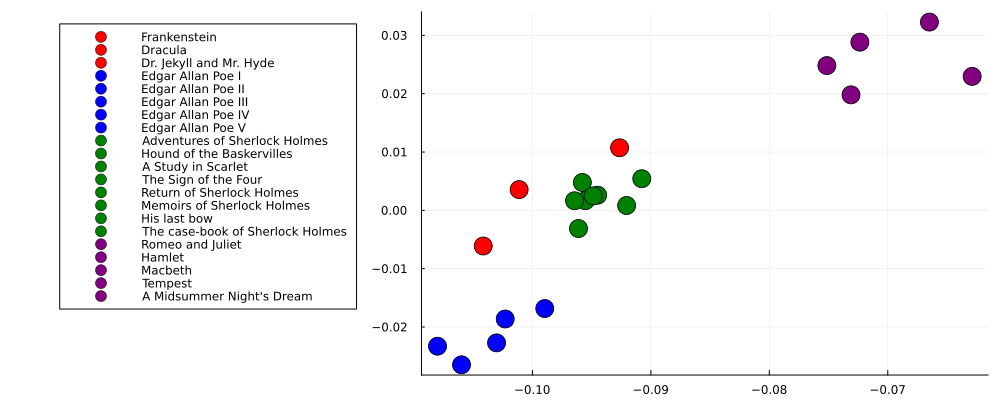

In [15]:
plt = scatter()
for i ∈ 1:n 
    scatter!(plt, [D[1,i]], [D[2,i]], #ylims=(-1,1),
        label=INFO[2:end][i][2], legend=:outertopleft, color=DOCS[i][end], size=(1000,400), markersize=10)
end
plot( plt )

6. Plot the first 2 dimensions in the matrix $D$. What do you notice about the plot?

We may compare different words and documents by comparing the corresponding rows of $W$ and columns of $D$. One normally compares these vectors using the *cosine similarity*: for two documents $d,d'$, let $u, u'$ be the corresponding columns of $D$ and define the cosine similarity between $d$ and $d'$ as 

\begin{align}
    \frac
        {u \cdot u'}
        {|u| |u'|}
\end{align}

In [16]:
function cs( i, j )
    u = D[:,i] 
    u′ = D[:,j]
    return dot( u, u′ ) / ( norm(u) * norm(u′) )
end;

7. What are the possible values of the cosine similarity?

Here, we view the *similarity matrix*:

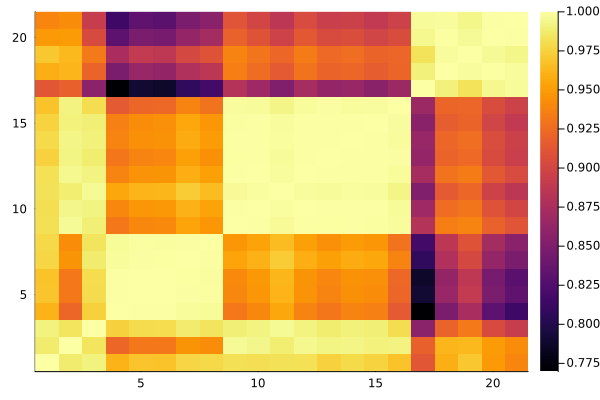

In [17]:
S = zeros(n,n)
for i=1:n 
    for j = 1:n 
        S[i,j] = cs( i, j  )
    end
end
heatmap( S )

8. What do you notice about this matrix? (Hint: recall that 1-3: gothic horror, 4-8: Edgar Allan Poe, 9-16: Sherlock Holmes, 17-21: Shakespeare, 22: Math)

9. Consider the story "A Study in Scarlet" (1887 detective novel by Arthur Conan Doyle introducing Sherlock Holmes for the first time). What do you expect to be the most similar other book? Compute the cosine similarity to confirm or dissprove your theory.

In [ ]:
println( S[ 11, argmax( S[11,1:10] )] )
println( S[ 11, argmax( S[11,12:end] ) ])

INFO[ argmax( S[11,1:10] ) ]

0.9986128845587086
0.9962121329923731


5-element Vector{Any}:
      9
       "Adventures of Sherlock Holmes"
 105679
   7874
       "green"

Imagine we want to compare a new text to our existing collection of documents. We could build a document-term vector for this new text and use the same projection to get a lower dimensional representation of this document. We do this in the following with the book "Tales of Horror and Mystery" by Arthur Conan Doyle.  

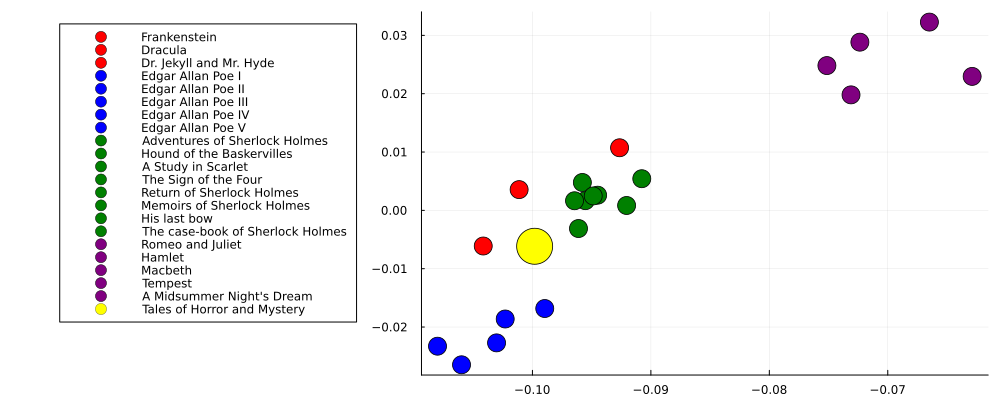

In [18]:
query = getText( "https://www.gutenberg.org/cache/epub/537/pg537.txt" )
L = length( query )

q = []
for w ∈ WORDS 
    push!( q, count(w′->w′==w, query)/L )
end

# q is like a new column in the orginal matrix
q′ = (P' * q)[1:k]

plt = scatter()
for i ∈ 1:n 
    scatter!(plt, [D[1,i]], [D[2,i]],
        label=INFO[2:end][i][2], legend=:outertopleft, color=DOCS[i][end], size=(1000,400), markersize=10)
end
scatter!(plt, [q′[1]], [q′[2]], label="Tales of Horror and Mystery", markersize=20, color="yellow" )
plot( plt )

10. What do you notice about this plot?

11. Copy some of your own text into the following variable:

In [19]:
text = "The evening had descended into a gray drizzle, and the gaslights of Baker Street cast quivering reflections on the wet pavement. I was seated by the fire, half-listening to the scratch of Holmes’s pen upon a notebook, when a sharp knock sounded at the door.

A young woman entered, her gloves damp and her eyes wide with anxiety.

“Mr. Holmes,” she began, “I fear something most peculiar has occurred at my father’s estate in Surrey. A valuable miniature has vanished, yet the door shows no sign of forced entry. None of the servants will speak of it, and I am utterly perplexed.”

Holmes rose, eyes gleaming. “Pray, Miss——?”

“Clermont,” she replied.

Holmes gestured for her to continue. “Your father keeps no unusual guests? No visitors of late?”

“None,” she said, wringing her handkerchief. “And yet, this morning, a single violet petal lay upon the drawing-room floor, as if to mock us.”

Holmes’s fingers twitched. He examined the petal with a magnifying glass, turning it gently. “Aha,” he murmured, “not merely a violet, but one from a rare hybrid cultivated only by the gardener at the northern end of the estate. See here—minute traces of ash upon the stem. The thief is familiar with the house, and has handled fire.”

I frowned. “But how does a single petal reveal the culprit?”

Holmes’s eyes sparkled. “Elementary, my dear Watson. Only one man could traverse the greenhouse, avoid detection, and carry a flower so delicately while leaving no other trace. The gardener himself—Mr. Kent—has taken the miniature, hoping to frighten the family into consulting him for protection. He relies on his knowledge of the estate and his own familiarity to evade suspicion.”

By the time we arrived at the Clermont estate, Mr. Kent was found seated nervously by the greenhouse, the missing miniature hidden beneath a loose floorboard, and a half-burnt violet leaf in his coat pocket.

Holmes returned to Baker Street that night with a faint smile. “You see, Watson, the smallest clue—an errant petal—can unlock the greatest of mysteries."

"The evening had descended into a gray drizzle, and the gaslights of Baker Street cast quivering reflections on the wet pavement. I was seated by the fire, half-listening to the scratch of Holmes’s pen upon a notebook, when a sharp knock sounded at the door.\n\nA young wom" ⋯ 1559 bytes ⋯ "reenhouse, the missing miniature hidden beneath a loose floorboard, and a half-burnt violet leaf in his coat pocket.\n\nHolmes returned to Baker Street that night with a faint smile. “You see, Watson, the smallest clue—an errant petal—can unlock the greatest of mysteries."

Where would you expect this text to sit in the lower dimensional respresentation of these text documents (i.e. in the plot)? Is your text more like mine, or Shakespeare? Confirm your hypothesis by running the code cell below. 

3-element Vector{Any}:
 -0.09590533975092494
 -0.023615526750431846
 -0.0015677409265134723

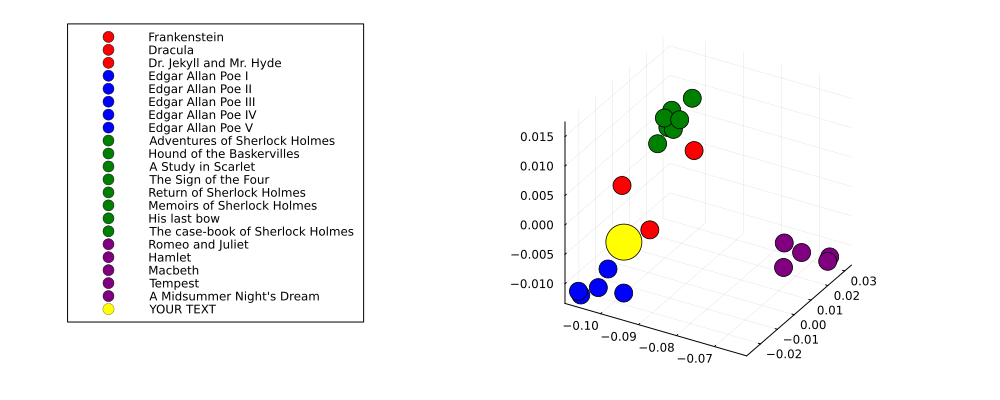

In [20]:
query = split.( lowercase( replace( text , r"[^A-Za-z0-9' ]" => " ") ) )
L = length( query )

q = []
for w ∈ WORDS 
    push!( q, count(w′->w′==w, query)/L )
end

# q is like a new column in the orginal matrix
q′ = (P' * q)[1:k]

display( q′ )

plt = scatter()
for i ∈ 1:n 
    scatter!(plt, [D[1,i]], [D[2,i]], [D[3,i]],
        label=INFO[2:end][i][2], legend=:outertopleft, color=DOCS[i][end], size=(1000,400), markersize=10)
end
scatter!(plt, [q′[1]], [q′[2]], [q′[3]], label="YOUR TEXT", markersize=20, color="yellow" )
plot( plt )